In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### download data

In [2]:
#! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
#! unzip ml-1m.zip

### define description and load data

In [3]:
age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
occupation_desc = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                   4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                   7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                   12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                   17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [4]:
rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

### change indices of user and movie

In [5]:
## there are gap in movie column, len(dataset['movieid'].unique())=3706, dataset['movieid'].max()=3952
## there are no gap in user column, len(dataset['userid'].unique())=6040, dataset['userid'].max()=6040

def check_cols(df, cols):
    return [(col, False) if len(dataset[col].unique())-1 == dataset[col].max() else (col, True) for col in cols]

def remove_gaps(df, col):
    adj_col_uni = df[col].sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0: col, 'index': "adj_%s"%(col,)})
    return pd.merge(adj_df, df, how="right", on=col)

index_cols = ["userid", "movieid"]
cols_check = check_cols(dataset, index_cols)
print_check = lambda check: print(*["%s needs fix!"%(c,) if f else "%s ok."%(c,) for c, f in check], sep="\n")
print("before fix:")
print_check(cols_check)
for col, needs_fix in cols_check:
    if needs_fix:
        dataset = remove_gaps(dataset, col)

print("\nafter fix")
print_check(check_cols(dataset, ["adj_userid", "adj_movieid"]))

before fix:
userid needs fix!
movieid needs fix!

after fix
adj_userid ok.
adj_movieid ok.


### add bias

In [6]:
b_movie = dataset[['adj_movieid', 'rating']].groupby(['adj_movieid']).agg(['mean']).reset_index()
b_movie.columns = b_movie.columns.droplevel(1)
b_movie.columns = ['adj_movieid', 'movie_mean']
b_user = dataset[['adj_userid', 'rating']].groupby(['adj_userid']).agg(['mean']).reset_index()
b_user.columns = b_user.columns.droplevel(1) 
b_user.columns = ['adj_userid', 'user_mean']
dataset = pd.merge(pd.merge(dataset,b_movie,how="left", on="adj_movieid"), b_user, how='left', on='adj_userid')
dataset['mean'] = np.mean(dataset[['rating']].values)

### train validation split

In [7]:
dataset = dataset.sample(frac=1, replace=False)
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

### build the model

In [8]:
def create_embeddings(num_users, num_movies, dim):
    user_embeddings = tf.get_variable(
        "theta",
        shape = [num_users, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_embeddings = tf.get_variable(
        "phi",
        shape = [num_movies, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_embeddings, movie_embeddings

def create_dataset(user_ids, movie_ids, ratings, user_mean, movie_mean, mean):
    user_id_var = tf.get_variable("userid", initializer=np.asarray(user_ids, dtype=np.int64), trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=np.asarray(movie_ids, dtype=np.int64), trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings, dtype=np.float32), trainable=False)
    overall_mean = tf.get_variable("overall_mean", initializer=np.asarray(mean, dtype=np.float32), trainable=False)
    user_bias = tf.get_variable("user_mean", initializer=np.asarray(user_mean, dtype=np.float32), trainable=False)
    movie_bias = tf.get_variable("movie_mean", initializer=np.asarray(user_mean, dtype=np.float32), trainable=False)
    user_dev = user_bias-overall_mean
    movie_dev = movie_bias-overall_mean
    return user_id_var, movie_id_var, ratings_var, user_dev, movie_dev, overall_mean

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids): 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return selected_user_embeddings, selected_movie_embeddings

def predict(selected_user_embeddings, selected_movie_embeddings, mean, user_dev, movie_dev):
    selected_predictions = tf.reduce_sum(
        selected_user_embeddings * selected_movie_embeddings,
        axis = 1) + mean + user_dev + movie_dev
    return selected_predictions 

def colaborative_filtering(user_embeddings, movie_embeddings, user_ids, movie_ids, mean, user_dev, movie_dev):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    predictions = predict(sel_usr_embs, sel_mov_embs, mean, user_dev, movie_dev)
    return predictions, sel_usr_embs, sel_mov_embs

def mean_squared_difference(predictions, ratings):
    difference = tf.reduce_mean(tf.squared_difference(predictions, ratings))
    return difference
        
def cal_reg_loss(predictions, ratings, lam, selected_user_embeddings, selected_movie_embeddings, user_dev, movie_dev):
    loss = mean_squared_difference(predictions, ratings)\
        + lam*tf.reduce_mean(tf.pow(selected_user_embeddings,2)) \
        + lam*tf.reduce_mean(tf.pow(selected_movie_embeddings,2))
    return loss

### set hyper parameters

In [9]:
emb_dim = 10
learning_rate = 50
epochs = 1600
lam = 0.02

### train model

In [10]:
with tf.Graph().as_default():
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = create_embeddings(dataset.adj_userid.max()+1, dataset.adj_movieid.max()+1, emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating", "user_mean", "movie_mean", "mean"]].values.T
        train_usr_ids, train_mov_ids, train_ratings, train_usr_dev, train_mov_dev, train_oa_mean = create_dataset(*train_data)
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating", "user_mean", "movie_mean", "mean"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings, valid_usr_dev, valid_mov_dev, valid_oa_mean = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_preds, usr_embs_reg, mov_embs_reg = colaborative_filtering(
            usr_embs, mov_embs, train_usr_ids, train_mov_ids, train_oa_mean, train_usr_dev, train_mov_dev)
        train_loss = cal_reg_loss(
            train_preds, train_ratings, lam, usr_embs_reg, mov_embs_reg, train_usr_dev, train_mov_dev)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs]) 
        real_train_loss = mean_squared_difference(train_preds,train_ratings)
    with tf.variable_scope("validation"):
        valid_preds, usr_embs_val, mov_embs_val = colaborative_filtering(
            usr_embs, mov_embs, valid_usr_ids, valid_mov_ids, valid_oa_mean, valid_usr_dev, valid_mov_dev)
        valid_loss = cal_reg_loss(
            valid_preds, valid_ratings, lam, usr_embs_val, usr_embs_val, valid_usr_dev, valid_mov_dev)
        real_valid_loss = mean_squared_difference(valid_preds,valid_ratings)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('Graph',sess.graph)
        sess.run(tf.global_variables_initializer())
        train_loss_history = []
        real_train_loss_history =[]
        real_valid_loss_history = []
        for i in range(epochs):
            current_train_loss, _ = sess.run([train_loss, train_usr_embs])
            #print("regularized train loss after %ith user emb. opt. step: %f"%(i+1, current_train_loss))
            current_train_loss, _ = sess.run([train_loss, train_mov_embs])
            #print("regularized train loss after %ith movie emb. opt. step: %f"%(i+1, current_train_loss))
            current_real_train_loss = sess.run(real_train_loss)
            current_real_valid_loss = sess.run(real_valid_loss)
            #print("real valid loss after %ith movie emb. opt. step: %f"%(i+1, current_real_valid_loss))
            train_loss_history.append(current_train_loss)
            real_train_loss_history.append(current_real_train_loss)
            real_valid_loss_history.append(current_real_valid_loss)
        final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds) 
        writer.close()

### plot losses

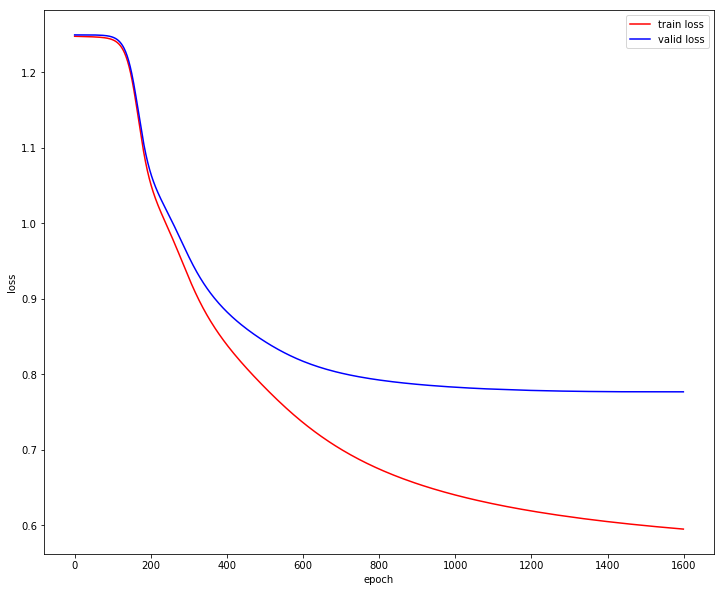

In [11]:
plt.figure(figsize=(12,10))
plt.plot(real_train_loss_history, color="red", label="train loss")
plt.plot(real_valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### results on validation set

In [12]:
results = validset[["gender", "age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction (rnd.)"] = np.asarray(np.round(final_valid_predictions), dtype=np.int16)
results["prediction (prc.)"] = final_valid_predictions
results

,gender,age_desc,occ_desc,title,genre,rating,prediction (rnd.),prediction (prc.)
446513,M,25-34,college/grad student,Contact (1997),Drama|Sci-Fi,5,4,3.680513
556145,M,25-34,college/grad student,Saving Private Ryan (1998),Action|Drama|War,5,4,3.837210
900412,M,25-34,unemployed,Death Wish 3 (1985),Action|Drama,2,3,2.962748
170168,F,35-44,scientist,Pinocchio (1940),Animation|Children's,3,4,3.881845
845645,M,18-24,other or not specified,Magnolia (1999),Drama,5,5,5.258866
608666,M,18-24,programmer,Say Anything... (1989),Comedy|Drama|Romance,3,4,3.910864
650619,M,25-34,other or not specified,Shakespeare in Love (1998),Comedy|Romance,3,4,3.954762
305246,M,50-55,executive/managerial,Aliens (1986),Action|Sci-Fi|Thriller|War,4,4,4.090771
142882,M,18-24,writer,Schindler's List (1993),Drama|War,4,4,4.324697
118407,M,56+,academic/educator,Dave (1993),Comedy|Romance,3,4,3.715916
